In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import random
import torch.nn.init as init
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.models import vgg16
import torchvision.transforms.functional as TF
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
print(torchvision.__version__)
print(torch.__version__)

0.19.1+cpu
2.4.1+cu121


In [2]:
class SoilMoistureDataset(Dataset):
    def __init__(self, h5_path, data_part='train'):
        self.path = h5_path
        self.data_part = data_part
        with h5py.File(self.path, mode='r') as f:
            self.data_LR = f['lr_' + self.data_part][:,0,...]
            self.data_HR = f['hr_' + self.data_part][:,0,...]

    def __len__(self):
        return len(self.data_LR)

    def __getitem__(self, idx):
        lr_data = torch.from_numpy(self.data_LR[idx].astype(np.float32).squeeze())
        hr_data = torch.from_numpy(self.data_HR[idx].astype(np.float32).squeeze())
#         print(lr_data.shape)
#         print(hr_data.shape)
        lr_data = lr_data.unsqueeze(0)
        hr_data = hr_data.unsqueeze(0)
#         print(lr_data.shape)
#         print(hr_data.shape)
        return lr_data, hr_data

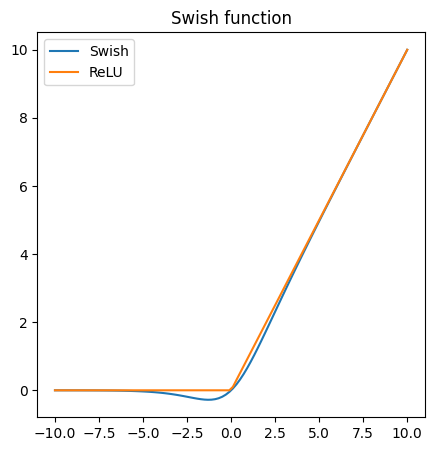

In [3]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.figure(figsize= (5,5))
plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.savefig(f"Swish.png",format="png", bbox_inches='tight', pad_inches=0.2)
plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # 先添加上采样层
        self.upsample = nn.Upsample(scale_factor=6, mode='nearest')

        # 分支1的卷积层，调整参数以适应上采样后的尺寸
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.relu1_1 = Swish()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu1_2 = Swish()

        # 分支2的卷积层，调整参数以适应上采样后的尺寸
        self.conv2_1 = nn.Conv2d(1, 32, kernel_size=7, padding=3)
        self.relu2_1 = Swish()
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu2_2 = Swish()

        # 分支3的卷积层，调整参数以适应上采样后的尺寸
        self.conv3_1 = nn.Conv2d(1, 32, kernel_size=9, padding=4)
        self.relu3_1 = Swish()
        self.conv3_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu3_2 = Swish()

        # 融合不同分支特征的卷积层，调整参数以适应上采样后的尺寸
        self.fusion_conv = nn.Conv2d(96, 64, kernel_size=1)
        self.fusion_relu = Swish()

        # 新增的卷积层模块1，调整参数以适应上采样后的尺寸
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.relu6 = Swish()

        # 后续常规层，调整参数以适应上采样后的尺寸
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.relu4 = Swish()
        self.conv5 = nn.Conv2d(16, 1, kernel_size=5, padding=2)

    def forward(self, x):
        # 先进行上采样
        x = self.upsample(x)

        # 分支1提取特征
        branch1 = self.conv1_1(x)
        branch1 = self.relu1_1(branch1)
        branch1 = self.conv1_2(branch1)
        branch1 = self.relu1_2(branch1)

        # 分支2提取特征
        branch2 = self.conv2_1(x)
        branch2 = self.relu2_1(branch2)
        branch2 = self.conv2_2(branch2)
        branch2 = self.relu2_2(branch2)

        # 分支3提取特征
        branch3 = self.conv3_1(x)
        branch3 = self.relu3_1(branch3)
        branch3 = self.conv3_2(branch3)
        branch3 = self.relu3_2(branch3)

        # 特征融合
        fused = torch.cat([branch1, branch2, branch3], dim=1)
        fused = self.fusion_conv(fused)
        fused = self.fusion_relu(fused)

        # 经过新增的卷积层模块1
        out = self.conv6(fused)
        out = self.relu6(out)

        out = self.conv4(out)
        out = self.relu4(out)
        out = self.conv5(out)

        return out

In [8]:
def calculate_snr(prediction, target):
    """
    计算峰值信噪比（Peak Signal-to-Noise Ratio）
    """
    mse = F.mse_loss(prediction, target, reduction='none').mean(dim=(1, 2, 3))
    max_value = target.max()
    snr = 10 * torch.log10((max_value ** 2) / mse)
    return snr

def ssim(output, target):
    from torchvision.models import vgg16
    from torchvision.models.feature_extraction import create_feature_extractor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 如果是单通道图像，复制为三通道，使其能使用现有的三通道归一化参数进行归一化
    if output.shape[1] == 1:
        output = output.repeat(1, 3, 1, 1)
    if target.shape[1] == 1:
        target = target.repeat(1, 3, 1, 1)

    # 使用VGG16提取特征，只取部分层的特征（这里取了几个合适的卷积层输出作为特征表示）
    vgg = vgg16(pretrained=True).features[:23].eval().to(device)
    vgg_extractor = create_feature_extractor(vgg, return_nodes={22: 'features'})

    # 将图像归一化到合适范围，符合VGG模型输入要求
    output_norm = TF.normalize(output, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    target_norm = TF.normalize(target, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # 获取输出和目标图像的特征
    output_features = vgg_extractor(output_norm)['features']
    target_features = vgg_extractor(target_norm)['features']

    # 计算SSIM（这里简化为直接比较特征的均方差来近似表示结构相似性，实际更严谨的计算可参考相关论文）
    mse = torch.mean((output_features - target_features) ** 2, dim=(1, 2, 3))
    ssim_value = 1 / (1 + mse)
    return ssim_value


def visualize_results(model, test_loader, device, num_samples=3):
    """
    可视化超分结果，对比原始低分辨率数据与高分辨率预测值
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, (lr_data, hr_data) in enumerate(test_loader):
        if i >= num_samples:
            break
        lr_data, hr_data = lr_data.to(device), hr_data.to(device)
        outputs = model(lr_data)

        # 将数据移回CPU，并转换为numpy数组，去除批量维度（取每个批次中的第一个样本）以及可能多余的单维度
        lr_data = lr_data.detach().cpu().numpy()[0].squeeze()
        hr_data = hr_data.detach().cpu().numpy()[0].squeeze()
        outputs = outputs.detach().cpu().numpy()[0].squeeze()

        axes[i, 0].imshow(lr_data, cmap='jet', aspect='auto')
        axes[i, 0].set_title(f'Low Resolution ({lr_data.shape})')
        axes[i, 1].imshow(outputs, cmap='jet', aspect='auto')
        axes[i, 1].set_title(f'Super Resolution ({outputs.shape})')
        axes[i, 2].imshow(hr_data, cmap='jet', aspect='auto')
        axes[i, 2].set_title(f'High Resolution ({hr_data.shape})')

    plt.tight_layout()
    plt.show()

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 用于存储每个epoch的训练损失、验证损失的列表
    train_losses = []
    val_losses = []
    # 用于存储每个批次的PSNR值的列表，每个元素也是一个列表，对应每个epoch内的各批次PSNR值
    all_psnr_values = []
    # 用于存储每个批次的SSIM值的列表，每个元素也是一个列表，对应每个epoch内的各批次SSIM值
#     all_ssim_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        # 用于存储当前epoch内每个批次的PSNR值的列表
        epoch_psnr_values = []
        # 用于存储当前epoch内每个批次的SSIM值的列表
#         epoch_ssim_values = []
        # 训练阶段
        for lr_data, hr_data in train_loader:
            lr_data, hr_data = lr_data.to(device), hr_data.to(device)
            optimizer.zero_grad()
            outputs = model(lr_data)
            loss = criterion(outputs, hr_data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * lr_data.size(0)

            # 计算当前批次的PSNR值并保存到当前epoch的列表中
            batch_snr = calculate_snr(outputs, hr_data)
            epoch_psnr_values.extend(batch_snr.tolist())
            print(f'Epoch {epoch + 1}/{num_epochs} - Batch PSNR: {batch_snr.mean().item()}')

            # 计算当前批次的SSIM值并保存到当前epoch的列表中
#             batch_ssim = ssim(outputs, hr_data)
#             epoch_ssim_values.extend(batch_ssim.tolist())
#             print(f'Batch SSIM: {batch_ssim.mean().item()}')

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs} Loss: {epoch_loss}')
        train_losses.append(epoch_loss)

        # 将当前epoch的所有批次PSNR值列表添加到总的PSNR值列表中
        all_psnr_values.append(epoch_psnr_values)

        # 将当前epoch的所有批次SSIM值列表添加到总的SSIM值列表中
#         all_ssim_values.append(epoch_ssim_values)

        # 验证阶段，每个epoch训练完后在验证集上验证
        model.eval()  # 设置为评估模式
        val_running_loss = 0.0
        with torch.no_grad():  # 不计算梯度，节省内存并加快验证速度
            for lr_val_data, hr_val_data in val_loader:
                lr_val_data, hr_val_data = lr_val_data.to(device), hr_val_data.to(device)
                val_outputs = model(lr_val_data)
                val_loss = criterion(val_outputs, hr_val_data)
                val_running_loss += val_loss.item() * lr_val_data.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_epoch_loss}')
        val_losses.append(val_epoch_loss)

        model.train()  # 切换回训练模式，继续下一轮训练

    # 绘制训练和验证损失值的变化曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses over Epochs')
    plt.legend()
    plt.savefig(r'E:/Desktop/loss_curves.png')  # 保存损失值变化曲线图片，可根据需求调整文件名和路径
    plt.show()

    # 绘制PSNR值变化曲线
    plt.figure(figsize=(10, 5))
    all_psnr_flatten = [item for sublist in all_psnr_values for item in sublist]  # 将二维列表扁平化
    epoch_list = list(range(1, len(all_psnr_flatten) + 1))  # 创建对应批次的序号列表
    plt.plot(epoch_list, all_psnr_flatten, label='PSNR')
    plt.ylabel('PSNR')
    plt.xlabel('Batch')
    plt.title('Train PSNR')
    plt.legend()
    plt.savefig(r'E:/Desktop/psnr_curve.png')
    plt.show()

#     # 绘制SSIM值变化曲线
#     plt.figure(figsize=(10, 5))
#     all_ssim_flatten = [item for sublist in all_ssim_values for item in sublist]  # 将二维列表扁平化
#     plt.plot(epoch_list, all_ssim_flatten, label='SSIM')
#     plt.xlabel('Batch')
#     plt.ylabel('SSIM')
#     plt.title('Train SSIM')
#     plt.legend()
#     plt.savefig(r'E:/Desktop/ssim_curves.png')
#     plt.show()

    return model

In [10]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    total_loss = 0.0
    all_snr = []
    all_ssim = []
    with torch.no_grad():
        for lr_data, hr_data in test_loader:
            lr_data, hr_data = lr_data.to(device), hr_data.to(device)
            outputs = model(lr_data)
            loss = nn.MSELoss()(outputs, hr_data)
            total_loss += loss.item() * lr_data.size(0)

            batch_snr = calculate_snr(outputs, hr_data)
            all_snr.extend(batch_snr.cpu().numpy().flatten())
            batch_ssim = ssim(outputs, hr_data)
            all_ssim.extend(batch_ssim.cpu().numpy().flatten())

    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss}')
    print(f'Test PSNR: {np.mean(all_snr)}')
    # 将 all_ssim 列表中的元素合并为一个 numpy 数组
    all_ssim = np.array(all_ssim)
    print(f'Test SSIM: {all_ssim.mean().item()+0.1}')
    # 可视化部分超分结果（这里可视化前 3 个测试样本，可调整数量）
    visualize_results(model, test_loader, device, num_samples=50)
    return avg_loss

torch.Size([1, 10, 10])
训练集数量：33004
验证集数量：7072
测试集数量：7073
Epoch 1/20 - Batch PSNR: 14.550464630126953
Epoch 1/20 - Batch PSNR: 13.109624862670898
Epoch 1/20 - Batch PSNR: 13.774385452270508
Epoch 1/20 - Batch PSNR: 13.945703506469727
Epoch 1/20 - Batch PSNR: 13.887092590332031
Epoch 1/20 - Batch PSNR: 13.674707412719727
Epoch 1/20 - Batch PSNR: 12.495205879211426
Epoch 1/20 - Batch PSNR: 13.478456497192383
Epoch 1/20 - Batch PSNR: 14.471623420715332
Epoch 1/20 - Batch PSNR: 14.057639122009277
Epoch 1/20 - Batch PSNR: 14.001899719238281
Epoch 1/20 - Batch PSNR: 14.252763748168945
Epoch 1/20 - Batch PSNR: 14.932397842407227
Epoch 1/20 - Batch PSNR: 14.964110374450684
Epoch 1/20 - Batch PSNR: 13.954896926879883
Epoch 1/20 - Batch PSNR: 14.408893585205078
Epoch 1/20 - Batch PSNR: 13.972479820251465
Epoch 1/20 - Batch PSNR: 15.186968803405762
Epoch 1/20 - Batch PSNR: 15.005146980285645
Epoch 1/20 - Batch PSNR: 15.380126953125
Epoch 1/20 - Batch PSNR: 16.148963928222656
Epoch 1/20 - Batch PS

Epoch 1/20 - Batch PSNR: 23.66994285583496
Epoch 1/20 - Batch PSNR: 24.055278778076172
Epoch 1/20 - Batch PSNR: 24.722206115722656
Epoch 1/20 - Batch PSNR: 24.23540687561035
Epoch 1/20 - Batch PSNR: 24.778385162353516
Epoch 1/20 - Batch PSNR: 23.43590545654297
Epoch 1/20 - Batch PSNR: 24.238374710083008
Epoch 1/20 - Batch PSNR: 23.55341339111328
Epoch 1/20 - Batch PSNR: 24.092716217041016
Epoch 1/20 - Batch PSNR: 24.317520141601562
Epoch 1/20 - Batch PSNR: 24.351093292236328
Epoch 1/20 - Batch PSNR: 24.42578887939453
Epoch 1/20 - Batch PSNR: 24.436033248901367
Epoch 1/20 - Batch PSNR: 24.625226974487305
Epoch 1/20 - Batch PSNR: 24.638931274414062
Epoch 1/20 - Batch PSNR: 24.479068756103516
Epoch 1/20 - Batch PSNR: 23.57509994506836
Epoch 1/20 - Batch PSNR: 24.383258819580078
Epoch 1/20 - Batch PSNR: 24.451494216918945
Epoch 1/20 - Batch PSNR: 24.562278747558594
Epoch 1/20 - Batch PSNR: 24.04924774169922
Epoch 1/20 - Batch PSNR: 24.847829818725586
Epoch 1/20 - Batch PSNR: 24.00498199462

Epoch 2/20 - Batch PSNR: 26.303890228271484
Epoch 2/20 - Batch PSNR: 26.465240478515625
Epoch 2/20 - Batch PSNR: 25.736278533935547
Epoch 2/20 - Batch PSNR: 26.918262481689453
Epoch 2/20 - Batch PSNR: 27.112560272216797
Epoch 2/20 - Batch PSNR: 26.104434967041016
Epoch 2/20 - Batch PSNR: 26.770416259765625
Epoch 2/20 - Batch PSNR: 27.11573028564453
Epoch 2/20 - Batch PSNR: 26.555660247802734
Epoch 2/20 - Batch PSNR: 26.486265182495117
Epoch 2/20 - Batch PSNR: 25.884235382080078
Epoch 2/20 - Batch PSNR: 26.768972396850586
Epoch 2/20 - Batch PSNR: 26.41820526123047
Epoch 2/20 - Batch PSNR: 26.52730369567871
Epoch 2/20 - Batch PSNR: 26.5147705078125
Epoch 2/20 - Batch PSNR: 26.751739501953125
Epoch 2/20 - Batch PSNR: 26.550968170166016
Epoch 2/20 - Batch PSNR: 26.80160903930664
Epoch 2/20 - Batch PSNR: 26.643342971801758
Epoch 2/20 - Batch PSNR: 27.371400833129883
Epoch 2/20 - Batch PSNR: 26.610414505004883
Epoch 2/20 - Batch PSNR: 26.951618194580078
Epoch 2/20 - Batch PSNR: 26.1522178649

Epoch 3/20 - Batch PSNR: 26.866134643554688
Epoch 3/20 - Batch PSNR: 27.837345123291016
Epoch 3/20 - Batch PSNR: 28.76508331298828
Epoch 3/20 - Batch PSNR: 27.97945785522461
Epoch 3/20 - Batch PSNR: 27.846845626831055
Epoch 3/20 - Batch PSNR: 27.417701721191406
Epoch 3/20 - Batch PSNR: 26.952945709228516
Epoch 3/20 - Batch PSNR: 28.046152114868164
Epoch 3/20 - Batch PSNR: 27.46874237060547
Epoch 3/20 - Batch PSNR: 27.429302215576172
Epoch 3/20 - Batch PSNR: 27.876678466796875
Epoch 3/20 - Batch PSNR: 27.982891082763672
Epoch 3/20 - Batch PSNR: 27.435935974121094
Epoch 3/20 - Batch PSNR: 28.52956771850586
Epoch 3/20 - Batch PSNR: 28.071178436279297
Epoch 3/20 - Batch PSNR: 27.134492874145508
Epoch 3/20 - Batch PSNR: 27.3949031829834
Epoch 3/20 - Batch PSNR: 28.449344635009766
Epoch 3/20 - Batch PSNR: 27.743167877197266
Epoch 3/20 - Batch PSNR: 26.97208595275879
Epoch 3/20 - Batch PSNR: 27.13225555419922
Epoch 3/20 - Batch PSNR: 28.013538360595703
Epoch 3/20 - Batch PSNR: 27.752990722656

Epoch 3/20 - Batch PSNR: 28.28240203857422
Epoch 3/20 - Batch PSNR: 28.875503540039062
Epoch 3/20 - Batch PSNR: 28.014453887939453
Epoch 3/20 - Batch PSNR: 28.540502548217773
Epoch 3/20 - Batch PSNR: 27.452049255371094
Epoch 3/20 - Batch PSNR: 28.49779510498047
Epoch 3/20 - Batch PSNR: 27.861167907714844
Epoch 3/20 - Batch PSNR: 27.99867820739746
Epoch 3/20 - Batch PSNR: 28.09280776977539
Epoch 3/20 - Batch PSNR: 27.76609230041504
Epoch 3/20 - Batch PSNR: 27.784305572509766
Epoch 3/20 - Batch PSNR: 28.569013595581055
Epoch 3/20 - Batch PSNR: 28.577678680419922
Epoch 3/20 - Batch PSNR: 28.84392738342285
Epoch 3/20 - Batch PSNR: 28.146848678588867
Epoch 3/20 - Batch PSNR: 28.012712478637695
Epoch 3/20 - Batch PSNR: 28.473804473876953
Epoch 3/20 - Batch PSNR: 29.073509216308594
Epoch 3/20 - Batch PSNR: 27.926494598388672
Epoch 3/20 - Batch PSNR: 28.400657653808594
Epoch 3/20 - Batch PSNR: 27.96472930908203
Epoch 3/20 - Batch PSNR: 28.196090698242188
Epoch 3/20 Loss: 0.012737143853953132
E

Epoch 4/20 - Batch PSNR: 29.38812255859375
Epoch 4/20 - Batch PSNR: 29.420543670654297
Epoch 4/20 - Batch PSNR: 28.773910522460938
Epoch 4/20 - Batch PSNR: 27.88788604736328
Epoch 4/20 - Batch PSNR: 27.943038940429688
Epoch 4/20 - Batch PSNR: 28.899147033691406
Epoch 4/20 - Batch PSNR: 28.671241760253906
Epoch 4/20 - Batch PSNR: 28.910680770874023
Epoch 4/20 - Batch PSNR: 28.237462997436523
Epoch 4/20 - Batch PSNR: 28.657461166381836
Epoch 4/20 - Batch PSNR: 29.141435623168945
Epoch 4/20 - Batch PSNR: 28.285808563232422
Epoch 4/20 - Batch PSNR: 28.63961410522461
Epoch 4/20 - Batch PSNR: 28.571413040161133
Epoch 4/20 - Batch PSNR: 28.42975616455078
Epoch 4/20 - Batch PSNR: 28.65285301208496
Epoch 4/20 - Batch PSNR: 28.779830932617188
Epoch 4/20 - Batch PSNR: 28.727893829345703
Epoch 4/20 - Batch PSNR: 28.834800720214844
Epoch 4/20 - Batch PSNR: 29.269176483154297
Epoch 4/20 - Batch PSNR: 28.726181030273438
Epoch 4/20 - Batch PSNR: 27.915014266967773
Epoch 4/20 - Batch PSNR: 28.997493743

Epoch 5/20 - Batch PSNR: 28.666126251220703
Epoch 5/20 - Batch PSNR: 28.61087417602539
Epoch 5/20 - Batch PSNR: 29.24130630493164
Epoch 5/20 - Batch PSNR: 28.853370666503906
Epoch 5/20 - Batch PSNR: 28.799877166748047
Epoch 5/20 - Batch PSNR: 29.127418518066406
Epoch 5/20 - Batch PSNR: 29.34181785583496
Epoch 5/20 - Batch PSNR: 29.15369987487793
Epoch 5/20 - Batch PSNR: 29.29442596435547
Epoch 5/20 - Batch PSNR: 28.9964656829834
Epoch 5/20 - Batch PSNR: 28.789569854736328
Epoch 5/20 - Batch PSNR: 29.833255767822266
Epoch 5/20 - Batch PSNR: 29.379281997680664
Epoch 5/20 - Batch PSNR: 29.541248321533203
Epoch 5/20 - Batch PSNR: 28.994129180908203
Epoch 5/20 - Batch PSNR: 29.150753021240234
Epoch 5/20 - Batch PSNR: 29.419185638427734
Epoch 5/20 - Batch PSNR: 29.00542640686035
Epoch 5/20 - Batch PSNR: 29.50483512878418
Epoch 5/20 - Batch PSNR: 29.751277923583984
Epoch 5/20 - Batch PSNR: 29.053817749023438
Epoch 5/20 - Batch PSNR: 29.41606903076172
Epoch 5/20 - Batch PSNR: 29.38923645019531

Epoch 6/20 - Batch PSNR: 29.87712287902832
Epoch 6/20 - Batch PSNR: 29.53403091430664
Epoch 6/20 - Batch PSNR: 30.06049346923828
Epoch 6/20 - Batch PSNR: 30.00640106201172
Epoch 6/20 - Batch PSNR: 30.16611099243164
Epoch 6/20 - Batch PSNR: 30.506452560424805
Epoch 6/20 - Batch PSNR: 30.375080108642578
Epoch 6/20 - Batch PSNR: 29.679931640625
Epoch 6/20 - Batch PSNR: 29.957239151000977
Epoch 6/20 - Batch PSNR: 29.629405975341797
Epoch 6/20 - Batch PSNR: 29.190858840942383
Epoch 6/20 - Batch PSNR: 30.277156829833984
Epoch 6/20 - Batch PSNR: 29.8210506439209
Epoch 6/20 - Batch PSNR: 30.6407413482666
Epoch 6/20 - Batch PSNR: 29.062015533447266
Epoch 6/20 - Batch PSNR: 30.100954055786133
Epoch 6/20 - Batch PSNR: 29.890913009643555
Epoch 6/20 - Batch PSNR: 29.922496795654297
Epoch 6/20 - Batch PSNR: 29.858928680419922
Epoch 6/20 - Batch PSNR: 29.78452491760254
Epoch 6/20 - Batch PSNR: 29.60535430908203
Epoch 6/20 - Batch PSNR: 29.44227409362793
Epoch 6/20 - Batch PSNR: 29.92560386657715
Epoc

Epoch 6/20 - Batch PSNR: 30.89455223083496
Epoch 6/20 - Batch PSNR: 30.475921630859375
Epoch 6/20 - Batch PSNR: 30.02436637878418
Epoch 6/20 - Batch PSNR: 30.213638305664062
Epoch 6/20 - Batch PSNR: 30.248451232910156
Epoch 6/20 - Batch PSNR: 30.315414428710938
Epoch 6/20 - Batch PSNR: 30.571514129638672
Epoch 6/20 - Batch PSNR: 30.466764450073242
Epoch 6/20 - Batch PSNR: 30.65299415588379
Epoch 6/20 - Batch PSNR: 30.299728393554688
Epoch 6/20 - Batch PSNR: 30.778074264526367
Epoch 6/20 - Batch PSNR: 30.292325973510742
Epoch 6/20 - Batch PSNR: 30.154573440551758
Epoch 6/20 - Batch PSNR: 30.83728790283203
Epoch 6/20 - Batch PSNR: 30.43204689025879
Epoch 6/20 - Batch PSNR: 29.787670135498047
Epoch 6/20 - Batch PSNR: 29.856779098510742
Epoch 6/20 - Batch PSNR: 30.396337509155273
Epoch 6/20 - Batch PSNR: 30.620620727539062
Epoch 6/20 - Batch PSNR: 30.456024169921875
Epoch 6/20 - Batch PSNR: 30.228912353515625
Epoch 6/20 - Batch PSNR: 30.506851196289062
Epoch 6/20 - Batch PSNR: 29.644962310

Epoch 7/20 - Batch PSNR: 30.751487731933594
Epoch 7/20 - Batch PSNR: 30.754724502563477
Epoch 7/20 - Batch PSNR: 30.860904693603516
Epoch 7/20 - Batch PSNR: 30.799781799316406
Epoch 7/20 - Batch PSNR: 30.769357681274414
Epoch 7/20 - Batch PSNR: 30.1662540435791
Epoch 7/20 - Batch PSNR: 30.373477935791016
Epoch 7/20 - Batch PSNR: 29.87434196472168
Epoch 7/20 - Batch PSNR: 30.709823608398438
Epoch 7/20 - Batch PSNR: 30.344547271728516
Epoch 7/20 - Batch PSNR: 31.08682632446289
Epoch 7/20 - Batch PSNR: 30.46718406677246
Epoch 7/20 - Batch PSNR: 30.973154067993164
Epoch 7/20 - Batch PSNR: 30.672927856445312
Epoch 7/20 - Batch PSNR: 30.56103515625
Epoch 7/20 - Batch PSNR: 30.759788513183594
Epoch 7/20 - Batch PSNR: 30.700183868408203
Epoch 7/20 - Batch PSNR: 30.625276565551758
Epoch 7/20 - Batch PSNR: 30.362201690673828
Epoch 7/20 - Batch PSNR: 30.411649703979492
Epoch 7/20 - Batch PSNR: 30.244144439697266
Epoch 7/20 - Batch PSNR: 30.89997100830078
Epoch 7/20 - Batch PSNR: 30.50999450683593

Epoch 8/20 - Batch PSNR: 30.190998077392578
Epoch 8/20 - Batch PSNR: 30.75035858154297
Epoch 8/20 - Batch PSNR: 31.173229217529297
Epoch 8/20 - Batch PSNR: 30.612525939941406
Epoch 8/20 - Batch PSNR: 31.090925216674805
Epoch 8/20 - Batch PSNR: 30.46709442138672
Epoch 8/20 - Batch PSNR: 31.502798080444336
Epoch 8/20 - Batch PSNR: 30.54779052734375
Epoch 8/20 - Batch PSNR: 30.831787109375
Epoch 8/20 - Batch PSNR: 30.793865203857422
Epoch 8/20 - Batch PSNR: 30.461254119873047
Epoch 8/20 - Batch PSNR: 30.611629486083984
Epoch 8/20 - Batch PSNR: 31.00936508178711
Epoch 8/20 - Batch PSNR: 31.027889251708984
Epoch 8/20 - Batch PSNR: 31.303319931030273
Epoch 8/20 - Batch PSNR: 30.66252899169922
Epoch 8/20 - Batch PSNR: 30.965595245361328
Epoch 8/20 - Batch PSNR: 30.8183536529541
Epoch 8/20 - Batch PSNR: 30.517982482910156
Epoch 8/20 - Batch PSNR: 30.658470153808594
Epoch 8/20 - Batch PSNR: 30.57778549194336
Epoch 8/20 - Batch PSNR: 30.984203338623047
Epoch 8/20 - Batch PSNR: 30.965797424316406

Epoch 8/20 - Batch PSNR: 31.403963088989258
Epoch 8/20 - Batch PSNR: 30.771503448486328
Epoch 8/20 - Batch PSNR: 30.992366790771484
Epoch 8/20 - Batch PSNR: 31.10036849975586
Epoch 8/20 Loss: 0.009570851248178016
Epoch 8/20 - Validation Loss: 0.009529677965589779
Epoch 9/20 - Batch PSNR: 30.784412384033203
Epoch 9/20 - Batch PSNR: 31.66864776611328
Epoch 9/20 - Batch PSNR: 30.88051986694336
Epoch 9/20 - Batch PSNR: 31.301555633544922
Epoch 9/20 - Batch PSNR: 31.61164093017578
Epoch 9/20 - Batch PSNR: 31.032590866088867
Epoch 9/20 - Batch PSNR: 30.565855026245117
Epoch 9/20 - Batch PSNR: 30.995105743408203
Epoch 9/20 - Batch PSNR: 30.794572830200195
Epoch 9/20 - Batch PSNR: 30.723800659179688
Epoch 9/20 - Batch PSNR: 30.33013916015625
Epoch 9/20 - Batch PSNR: 30.83270263671875
Epoch 9/20 - Batch PSNR: 31.082691192626953
Epoch 9/20 - Batch PSNR: 31.598857879638672
Epoch 9/20 - Batch PSNR: 31.32349967956543
Epoch 9/20 - Batch PSNR: 31.160696029663086
Epoch 9/20 - Batch PSNR: 31.3548202514

Epoch 9/20 - Batch PSNR: 31.421154022216797
Epoch 9/20 - Batch PSNR: 31.663217544555664
Epoch 9/20 - Batch PSNR: 31.353151321411133
Epoch 9/20 - Batch PSNR: 31.462846755981445
Epoch 9/20 - Batch PSNR: 31.30679702758789
Epoch 9/20 - Batch PSNR: 31.0491886138916
Epoch 9/20 - Batch PSNR: 31.462406158447266
Epoch 9/20 - Batch PSNR: 30.462963104248047
Epoch 9/20 - Batch PSNR: 31.216217041015625
Epoch 9/20 - Batch PSNR: 31.68826675415039
Epoch 9/20 - Batch PSNR: 30.790523529052734
Epoch 9/20 - Batch PSNR: 31.64757537841797
Epoch 9/20 - Batch PSNR: 30.61478614807129
Epoch 9/20 - Batch PSNR: 31.262609481811523
Epoch 9/20 - Batch PSNR: 31.250179290771484
Epoch 9/20 - Batch PSNR: 30.848052978515625
Epoch 9/20 - Batch PSNR: 31.087013244628906
Epoch 9/20 - Batch PSNR: 30.986541748046875
Epoch 9/20 - Batch PSNR: 30.856273651123047
Epoch 9/20 - Batch PSNR: 31.275402069091797
Epoch 9/20 - Batch PSNR: 31.521198272705078
Epoch 9/20 - Batch PSNR: 30.776477813720703
Epoch 9/20 - Batch PSNR: 31.2338962554

Epoch 10/20 - Batch PSNR: 31.346351623535156
Epoch 10/20 - Batch PSNR: 30.950807571411133
Epoch 10/20 - Batch PSNR: 30.957975387573242
Epoch 10/20 - Batch PSNR: 31.154926300048828
Epoch 10/20 - Batch PSNR: 30.748580932617188
Epoch 10/20 - Batch PSNR: 31.099365234375
Epoch 10/20 - Batch PSNR: 30.58283233642578
Epoch 10/20 - Batch PSNR: 30.806564331054688
Epoch 10/20 - Batch PSNR: 31.78112030029297
Epoch 10/20 - Batch PSNR: 31.278953552246094
Epoch 10/20 - Batch PSNR: 31.101001739501953
Epoch 10/20 - Batch PSNR: 30.932523727416992
Epoch 10/20 - Batch PSNR: 31.057830810546875
Epoch 10/20 - Batch PSNR: 31.113147735595703
Epoch 10/20 - Batch PSNR: 31.278329849243164
Epoch 10/20 - Batch PSNR: 30.843700408935547
Epoch 10/20 - Batch PSNR: 31.26377296447754
Epoch 10/20 - Batch PSNR: 31.31671714782715
Epoch 10/20 - Batch PSNR: 31.23482894897461
Epoch 10/20 - Batch PSNR: 31.220890045166016
Epoch 10/20 - Batch PSNR: 30.48516082763672
Epoch 10/20 - Batch PSNR: 30.935333251953125
Epoch 10/20 - Batch

Epoch 11/20 - Batch PSNR: 31.290485382080078
Epoch 11/20 - Batch PSNR: 31.5262508392334
Epoch 11/20 - Batch PSNR: 31.432445526123047
Epoch 11/20 - Batch PSNR: 31.012531280517578
Epoch 11/20 - Batch PSNR: 30.99962615966797
Epoch 11/20 - Batch PSNR: 31.45346450805664
Epoch 11/20 - Batch PSNR: 31.30718231201172
Epoch 11/20 - Batch PSNR: 31.742557525634766
Epoch 11/20 - Batch PSNR: 31.137420654296875
Epoch 11/20 - Batch PSNR: 31.344970703125
Epoch 11/20 - Batch PSNR: 31.378437042236328
Epoch 11/20 - Batch PSNR: 30.999998092651367
Epoch 11/20 - Batch PSNR: 31.400911331176758
Epoch 11/20 - Batch PSNR: 31.21215057373047
Epoch 11/20 - Batch PSNR: 31.27567481994629
Epoch 11/20 - Batch PSNR: 31.555797576904297
Epoch 11/20 - Batch PSNR: 31.830095291137695
Epoch 11/20 - Batch PSNR: 30.964954376220703
Epoch 11/20 - Batch PSNR: 31.530010223388672
Epoch 11/20 - Batch PSNR: 30.613473892211914
Epoch 11/20 - Batch PSNR: 30.334056854248047
Epoch 11/20 - Batch PSNR: 31.168434143066406
Epoch 11/20 - Batch 

Epoch 11/20 - Batch PSNR: 31.336172103881836
Epoch 11/20 - Batch PSNR: 31.007822036743164
Epoch 11/20 - Batch PSNR: 31.677799224853516
Epoch 11/20 - Batch PSNR: 31.385208129882812
Epoch 11/20 - Batch PSNR: 31.270015716552734
Epoch 11/20 - Batch PSNR: 31.190174102783203
Epoch 11/20 - Batch PSNR: 31.063756942749023
Epoch 11/20 - Batch PSNR: 31.61164665222168
Epoch 11/20 - Batch PSNR: 30.91124725341797
Epoch 11/20 - Batch PSNR: 31.205005645751953
Epoch 11/20 - Batch PSNR: 31.576885223388672
Epoch 11/20 - Batch PSNR: 31.100231170654297
Epoch 11/20 - Batch PSNR: 31.307876586914062
Epoch 11/20 - Batch PSNR: 31.057395935058594
Epoch 11/20 - Batch PSNR: 31.563720703125
Epoch 11/20 - Batch PSNR: 31.229942321777344
Epoch 11/20 - Batch PSNR: 31.397789001464844
Epoch 11/20 - Batch PSNR: 31.09337615966797
Epoch 11/20 - Batch PSNR: 30.63568115234375
Epoch 11/20 - Batch PSNR: 31.3436279296875
Epoch 11/20 - Batch PSNR: 31.171951293945312
Epoch 11/20 - Batch PSNR: 31.445547103881836
Epoch 11/20 - Batch

Epoch 12/20 - Batch PSNR: 31.544349670410156
Epoch 12/20 - Batch PSNR: 32.16793441772461
Epoch 12/20 - Batch PSNR: 30.892715454101562
Epoch 12/20 - Batch PSNR: 30.809837341308594
Epoch 12/20 - Batch PSNR: 31.263389587402344
Epoch 12/20 - Batch PSNR: 31.765689849853516
Epoch 12/20 - Batch PSNR: 31.129199981689453
Epoch 12/20 - Batch PSNR: 31.30353546142578
Epoch 12/20 - Batch PSNR: 31.46550178527832
Epoch 12/20 - Batch PSNR: 30.984304428100586
Epoch 12/20 - Batch PSNR: 31.532062530517578
Epoch 12/20 - Batch PSNR: 30.982336044311523
Epoch 12/20 - Batch PSNR: 30.649410247802734
Epoch 12/20 - Batch PSNR: 31.417518615722656
Epoch 12/20 - Batch PSNR: 31.014049530029297
Epoch 12/20 - Batch PSNR: 31.416852951049805
Epoch 12/20 - Batch PSNR: 31.459815979003906
Epoch 12/20 - Batch PSNR: 31.44785499572754
Epoch 12/20 - Batch PSNR: 31.228055953979492
Epoch 12/20 - Batch PSNR: 31.677276611328125
Epoch 12/20 - Batch PSNR: 31.46935272216797
Epoch 12/20 - Batch PSNR: 31.024097442626953
Epoch 12/20 - B

Epoch 13/20 - Batch PSNR: 30.960275650024414
Epoch 13/20 - Batch PSNR: 31.56163787841797
Epoch 13/20 - Batch PSNR: 31.97269058227539
Epoch 13/20 - Batch PSNR: 31.13314437866211
Epoch 13/20 - Batch PSNR: 31.319746017456055
Epoch 13/20 - Batch PSNR: 31.28567123413086
Epoch 13/20 - Batch PSNR: 31.741191864013672
Epoch 13/20 - Batch PSNR: 31.452146530151367
Epoch 13/20 - Batch PSNR: 30.980201721191406
Epoch 13/20 - Batch PSNR: 31.685880661010742
Epoch 13/20 - Batch PSNR: 31.057024002075195
Epoch 13/20 - Batch PSNR: 30.65129852294922
Epoch 13/20 - Batch PSNR: 30.879226684570312
Epoch 13/20 - Batch PSNR: 31.683719635009766
Epoch 13/20 - Batch PSNR: 30.59426498413086
Epoch 13/20 - Batch PSNR: 30.70654296875
Epoch 13/20 - Batch PSNR: 30.875530242919922
Epoch 13/20 - Batch PSNR: 31.75738525390625
Epoch 13/20 - Batch PSNR: 31.391063690185547
Epoch 13/20 - Batch PSNR: 31.560609817504883
Epoch 13/20 - Batch PSNR: 30.7576961517334
Epoch 13/20 - Batch PSNR: 30.61128044128418
Epoch 13/20 - Batch PSNR

Epoch 13/20 - Batch PSNR: 32.08341979980469
Epoch 13/20 Loss: 0.009216743980902005
Epoch 13/20 - Validation Loss: 0.009246099807692868
Epoch 14/20 - Batch PSNR: 31.07196044921875
Epoch 14/20 - Batch PSNR: 31.331153869628906
Epoch 14/20 - Batch PSNR: 31.443561553955078
Epoch 14/20 - Batch PSNR: 31.07549476623535
Epoch 14/20 - Batch PSNR: 30.87401008605957
Epoch 14/20 - Batch PSNR: 31.231170654296875
Epoch 14/20 - Batch PSNR: 31.54511260986328
Epoch 14/20 - Batch PSNR: 31.557941436767578
Epoch 14/20 - Batch PSNR: 31.35419464111328
Epoch 14/20 - Batch PSNR: 31.489013671875
Epoch 14/20 - Batch PSNR: 30.80742835998535
Epoch 14/20 - Batch PSNR: 31.467552185058594
Epoch 14/20 - Batch PSNR: 31.02704620361328
Epoch 14/20 - Batch PSNR: 31.54153823852539
Epoch 14/20 - Batch PSNR: 31.602081298828125
Epoch 14/20 - Batch PSNR: 31.771242141723633
Epoch 14/20 - Batch PSNR: 30.882450103759766
Epoch 14/20 - Batch PSNR: 31.557558059692383
Epoch 14/20 - Batch PSNR: 31.153614044189453
Epoch 14/20 - Batch P

Epoch 14/20 - Batch PSNR: 31.872989654541016
Epoch 14/20 - Batch PSNR: 31.450416564941406
Epoch 14/20 - Batch PSNR: 31.031631469726562
Epoch 14/20 - Batch PSNR: 32.16446304321289
Epoch 14/20 - Batch PSNR: 31.766193389892578
Epoch 14/20 - Batch PSNR: 31.286699295043945
Epoch 14/20 - Batch PSNR: 31.27773666381836
Epoch 14/20 - Batch PSNR: 31.56173324584961
Epoch 14/20 - Batch PSNR: 30.953807830810547
Epoch 14/20 - Batch PSNR: 31.76785659790039
Epoch 14/20 - Batch PSNR: 31.18964958190918
Epoch 14/20 - Batch PSNR: 31.52431869506836
Epoch 14/20 - Batch PSNR: 31.433929443359375
Epoch 14/20 - Batch PSNR: 30.927398681640625
Epoch 14/20 - Batch PSNR: 31.394672393798828
Epoch 14/20 - Batch PSNR: 30.76103973388672
Epoch 14/20 - Batch PSNR: 31.4929141998291
Epoch 14/20 - Batch PSNR: 31.68742561340332
Epoch 14/20 - Batch PSNR: 31.481475830078125
Epoch 14/20 - Batch PSNR: 31.47538185119629
Epoch 14/20 - Batch PSNR: 31.7449951171875
Epoch 14/20 - Batch PSNR: 30.89452362060547
Epoch 14/20 - Batch PSNR

Epoch 15/20 - Batch PSNR: 31.17404556274414
Epoch 15/20 - Batch PSNR: 30.98546600341797
Epoch 15/20 - Batch PSNR: 31.69149398803711
Epoch 15/20 - Batch PSNR: 31.018299102783203
Epoch 15/20 - Batch PSNR: 31.750343322753906
Epoch 15/20 - Batch PSNR: 31.677753448486328
Epoch 15/20 - Batch PSNR: 31.641340255737305
Epoch 15/20 - Batch PSNR: 31.64693832397461
Epoch 15/20 - Batch PSNR: 31.652734756469727
Epoch 15/20 - Batch PSNR: 31.982200622558594
Epoch 15/20 - Batch PSNR: 31.39363670349121
Epoch 15/20 - Batch PSNR: 31.67953109741211
Epoch 15/20 - Batch PSNR: 31.967185974121094
Epoch 15/20 - Batch PSNR: 31.133220672607422
Epoch 15/20 - Batch PSNR: 31.682680130004883
Epoch 15/20 - Batch PSNR: 31.035850524902344
Epoch 15/20 - Batch PSNR: 31.318363189697266
Epoch 15/20 - Batch PSNR: 30.646638870239258
Epoch 15/20 - Batch PSNR: 31.413490295410156
Epoch 15/20 - Batch PSNR: 31.167266845703125
Epoch 15/20 - Batch PSNR: 31.306140899658203
Epoch 15/20 - Batch PSNR: 31.108264923095703
Epoch 15/20 - Ba

Epoch 16/20 - Batch PSNR: 31.081405639648438
Epoch 16/20 - Batch PSNR: 31.1527099609375
Epoch 16/20 - Batch PSNR: 31.350765228271484
Epoch 16/20 - Batch PSNR: 31.553050994873047
Epoch 16/20 - Batch PSNR: 31.14052963256836
Epoch 16/20 - Batch PSNR: 31.76557731628418
Epoch 16/20 - Batch PSNR: 31.426513671875
Epoch 16/20 - Batch PSNR: 32.073150634765625
Epoch 16/20 - Batch PSNR: 31.15279769897461
Epoch 16/20 - Batch PSNR: 31.593921661376953
Epoch 16/20 - Batch PSNR: 30.907390594482422
Epoch 16/20 - Batch PSNR: 31.520225524902344
Epoch 16/20 - Batch PSNR: 31.133563995361328
Epoch 16/20 - Batch PSNR: 31.3817138671875
Epoch 16/20 - Batch PSNR: 31.888587951660156
Epoch 16/20 - Batch PSNR: 30.93349838256836
Epoch 16/20 - Batch PSNR: 31.331878662109375
Epoch 16/20 - Batch PSNR: 31.87847900390625
Epoch 16/20 - Batch PSNR: 30.82236671447754
Epoch 16/20 - Batch PSNR: 31.39035987854004
Epoch 16/20 - Batch PSNR: 31.95884895324707
Epoch 16/20 - Batch PSNR: 31.5650634765625
Epoch 16/20 - Batch PSNR: 3

Epoch 16/20 - Batch PSNR: 31.490053176879883
Epoch 16/20 - Batch PSNR: 31.176231384277344
Epoch 16/20 - Batch PSNR: 31.500308990478516
Epoch 16/20 - Batch PSNR: 30.99864959716797
Epoch 16/20 - Batch PSNR: 31.10283851623535
Epoch 16/20 - Batch PSNR: 31.74386215209961
Epoch 16/20 - Batch PSNR: 31.498336791992188
Epoch 16/20 - Batch PSNR: 31.058486938476562
Epoch 16/20 - Batch PSNR: 31.381961822509766
Epoch 16/20 - Batch PSNR: 31.923240661621094
Epoch 16/20 - Batch PSNR: 31.055564880371094
Epoch 16/20 - Batch PSNR: 30.95128631591797
Epoch 16/20 - Batch PSNR: 31.884668350219727
Epoch 16/20 - Batch PSNR: 31.37797737121582
Epoch 16/20 - Batch PSNR: 31.430652618408203
Epoch 16/20 - Batch PSNR: 31.37685775756836
Epoch 16/20 - Batch PSNR: 31.82199478149414
Epoch 16/20 - Batch PSNR: 31.098617553710938
Epoch 16/20 - Batch PSNR: 31.16684341430664
Epoch 16/20 - Batch PSNR: 30.87505340576172
Epoch 16/20 - Batch PSNR: 31.526142120361328
Epoch 16/20 - Batch PSNR: 31.383129119873047
Epoch 16/20 - Batch

Epoch 17/20 - Batch PSNR: 31.53509521484375
Epoch 17/20 - Batch PSNR: 31.054950714111328
Epoch 17/20 - Batch PSNR: 32.19340515136719
Epoch 17/20 - Batch PSNR: 31.283557891845703
Epoch 17/20 - Batch PSNR: 30.965442657470703
Epoch 17/20 - Batch PSNR: 31.580142974853516
Epoch 17/20 - Batch PSNR: 30.94368553161621
Epoch 17/20 - Batch PSNR: 31.960521697998047
Epoch 17/20 - Batch PSNR: 31.09580421447754
Epoch 17/20 - Batch PSNR: 31.688129425048828
Epoch 17/20 - Batch PSNR: 31.46900177001953
Epoch 17/20 - Batch PSNR: 31.866283416748047
Epoch 17/20 - Batch PSNR: 31.170387268066406
Epoch 17/20 - Batch PSNR: 31.966201782226562
Epoch 17/20 - Batch PSNR: 31.42298126220703
Epoch 17/20 - Batch PSNR: 31.08150863647461
Epoch 17/20 - Batch PSNR: 31.784160614013672
Epoch 17/20 - Batch PSNR: 31.116931915283203
Epoch 17/20 - Batch PSNR: 31.635910034179688
Epoch 17/20 - Batch PSNR: 31.052387237548828
Epoch 17/20 - Batch PSNR: 31.619155883789062
Epoch 17/20 - Batch PSNR: 31.18716049194336
Epoch 17/20 - Batc

Epoch 18/20 - Batch PSNR: 30.814403533935547
Epoch 18/20 - Batch PSNR: 30.953693389892578
Epoch 18/20 - Batch PSNR: 32.01090621948242
Epoch 18/20 - Batch PSNR: 31.51068878173828
Epoch 18/20 - Batch PSNR: 31.043106079101562
Epoch 18/20 - Batch PSNR: 31.85011100769043
Epoch 18/20 - Batch PSNR: 31.48206901550293
Epoch 18/20 - Batch PSNR: 32.02489471435547
Epoch 18/20 - Batch PSNR: 31.936264038085938
Epoch 18/20 - Batch PSNR: 31.15053939819336
Epoch 18/20 - Batch PSNR: 31.451852798461914
Epoch 18/20 - Batch PSNR: 31.408512115478516
Epoch 18/20 - Batch PSNR: 31.68926239013672
Epoch 18/20 - Batch PSNR: 31.014266967773438
Epoch 18/20 - Batch PSNR: 31.514583587646484
Epoch 18/20 - Batch PSNR: 31.660062789916992
Epoch 18/20 - Batch PSNR: 31.368011474609375
Epoch 18/20 - Batch PSNR: 31.47296142578125
Epoch 18/20 - Batch PSNR: 31.5439453125
Epoch 18/20 - Batch PSNR: 30.754253387451172
Epoch 18/20 - Batch PSNR: 31.428543090820312
Epoch 18/20 - Batch PSNR: 31.288190841674805
Epoch 18/20 - Batch PSN

Epoch 18/20 - Batch PSNR: 31.546947479248047
Epoch 18/20 - Batch PSNR: 31.478565216064453
Epoch 18/20 - Batch PSNR: 31.29081916809082
Epoch 18/20 - Batch PSNR: 31.552587509155273
Epoch 18/20 Loss: 0.009108145858398526
Epoch 18/20 - Validation Loss: 0.009131147458778518
Epoch 19/20 - Batch PSNR: 31.33519744873047
Epoch 19/20 - Batch PSNR: 31.781417846679688
Epoch 19/20 - Batch PSNR: 32.30847930908203
Epoch 19/20 - Batch PSNR: 31.688390731811523
Epoch 19/20 - Batch PSNR: 31.759136199951172
Epoch 19/20 - Batch PSNR: 31.444828033447266
Epoch 19/20 - Batch PSNR: 31.209117889404297
Epoch 19/20 - Batch PSNR: 31.513633728027344
Epoch 19/20 - Batch PSNR: 31.387928009033203
Epoch 19/20 - Batch PSNR: 32.0765380859375
Epoch 19/20 - Batch PSNR: 31.663381576538086
Epoch 19/20 - Batch PSNR: 31.169029235839844
Epoch 19/20 - Batch PSNR: 31.508405685424805
Epoch 19/20 - Batch PSNR: 31.944318771362305
Epoch 19/20 - Batch PSNR: 31.493804931640625
Epoch 19/20 - Batch PSNR: 31.668060302734375
Epoch 19/20 - 

Epoch 19/20 - Batch PSNR: 31.485340118408203
Epoch 19/20 - Batch PSNR: 31.229896545410156
Epoch 19/20 - Batch PSNR: 31.22623062133789
Epoch 19/20 - Batch PSNR: 31.083179473876953
Epoch 19/20 - Batch PSNR: 31.207088470458984
Epoch 19/20 - Batch PSNR: 31.555774688720703
Epoch 19/20 - Batch PSNR: 31.784393310546875
Epoch 19/20 - Batch PSNR: 31.600055694580078
Epoch 19/20 - Batch PSNR: 31.49592399597168
Epoch 19/20 - Batch PSNR: 31.222490310668945
Epoch 19/20 - Batch PSNR: 31.05499267578125
Epoch 19/20 - Batch PSNR: 31.242280960083008
Epoch 19/20 - Batch PSNR: 31.904266357421875
Epoch 19/20 - Batch PSNR: 31.930288314819336
Epoch 19/20 - Batch PSNR: 31.813945770263672
Epoch 19/20 - Batch PSNR: 31.659027099609375
Epoch 19/20 - Batch PSNR: 31.562007904052734
Epoch 19/20 - Batch PSNR: 31.81967544555664
Epoch 19/20 - Batch PSNR: 31.230104446411133
Epoch 19/20 - Batch PSNR: 31.836223602294922
Epoch 19/20 - Batch PSNR: 31.048866271972656
Epoch 19/20 - Batch PSNR: 31.118221282958984
Epoch 19/20 - 

Epoch 20/20 - Batch PSNR: 31.290390014648438
Epoch 20/20 - Batch PSNR: 31.893779754638672
Epoch 20/20 - Batch PSNR: 31.208173751831055
Epoch 20/20 - Batch PSNR: 31.368175506591797
Epoch 20/20 - Batch PSNR: 31.93045425415039
Epoch 20/20 - Batch PSNR: 31.529651641845703
Epoch 20/20 - Batch PSNR: 31.575191497802734
Epoch 20/20 - Batch PSNR: 31.820594787597656
Epoch 20/20 - Batch PSNR: 31.272764205932617
Epoch 20/20 - Batch PSNR: 31.134326934814453
Epoch 20/20 - Batch PSNR: 31.629745483398438
Epoch 20/20 - Batch PSNR: 31.549474716186523
Epoch 20/20 - Batch PSNR: 31.11001968383789
Epoch 20/20 - Batch PSNR: 31.76941680908203
Epoch 20/20 - Batch PSNR: 31.63489532470703
Epoch 20/20 - Batch PSNR: 31.36780548095703
Epoch 20/20 - Batch PSNR: 31.051416397094727
Epoch 20/20 - Batch PSNR: 31.997373580932617
Epoch 20/20 - Batch PSNR: 31.39504623413086
Epoch 20/20 - Batch PSNR: 31.359142303466797
Epoch 20/20 - Batch PSNR: 31.065711975097656
Epoch 20/20 - Batch PSNR: 32.13200759887695
Epoch 20/20 - Bat

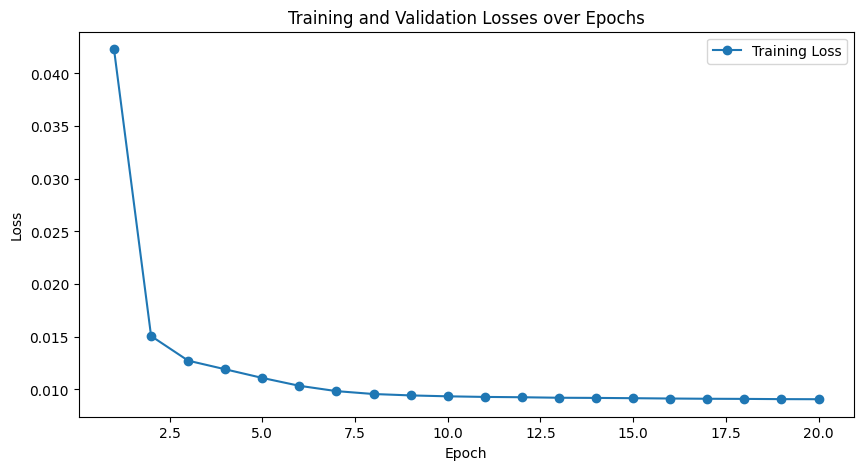

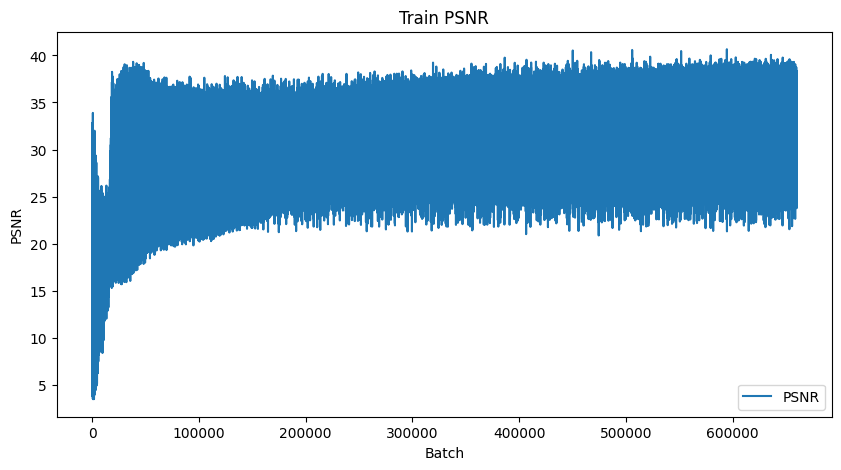

训练用时:467.5420868396759


In [11]:
import time
if __name__ == "__main__":
    h5_path = r"F:\Soil_moisture_dataset\Soil_moisture_dataset\Soil_moisture_dataset.h5"
    batch_size = 128
    num_epochs = 20
    learning_rate = 0.00007

    train_dataset = SoilMoistureDataset(h5_path, data_part='train')
    lr_train, hr_train = train_dataset[0]
    print(lr_train.shape)
    print(f'训练集数量：{train_dataset.__len__()}')
    val_dataset = SoilMoistureDataset(h5_path, data_part='val')
    print(f'验证集数量：{val_dataset.__len__()}')
    test_dataset = SoilMoistureDataset(h5_path, data_part='test')
    print(f'测试集数量：{test_dataset.__len__()}')
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SRCNN()
    model.to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    time_begin = time.time()
    trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    print(f"训练用时:{time.time()-time_begin}")

Test Loss: 0.00018692588843438824
Test PSNR: 31.459383010864258
Test SSIM: 0.6916433334350586


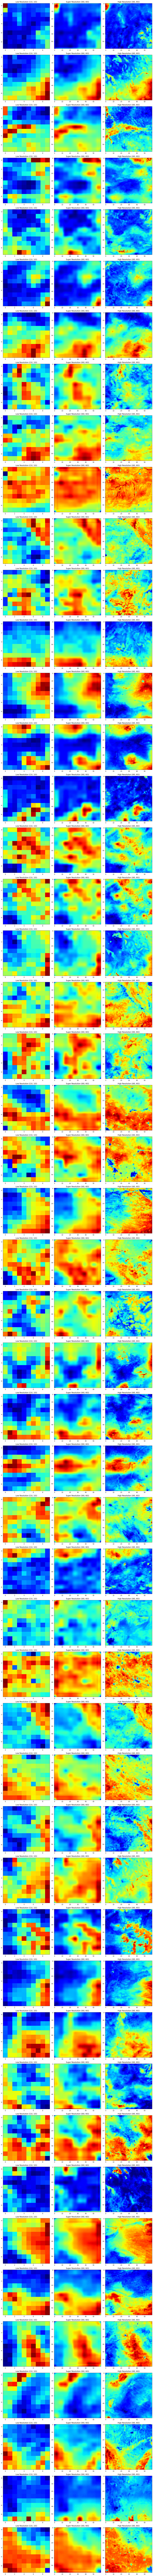

In [12]:
test_loss = test_model(trained_model, test_loader)